In [1]:
#Import some libraries
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_rows = 2200
pd.options.display.max_columns = 2200

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier as cat
from sklearn.metrics import roc_auc_score,log_loss
# from imblearn.over_sampling import SMOTE,RandomOverSampler
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv('trainlgbimputed2.csv')
test=  pd.read_csv('testlgbimputed2.csv')
submission = pd.read_csv('sample_submission.csv')

In [3]:
train.shape, test.shape

((70000, 161), (30000, 160))

In [4]:
train.head()

,feature_2,feature_189,feature_191_year,feature_81,feature_206,feature_159,feature_457,feature_352,feature_17,feature_168,feature_7,feature_307,feature_186,feature_297,feature_92,feature_169,feature_177,feature_350,feature_164,feature_13,feature_247,feature_222,feature_214,feature_170,feature_89,feature_264,feature_387,feature_238,feature_201_year,feature_153,feature_223,feature_160,feature_60,feature_3,feature_232,feature_356,feature_220,feature_218,feature_216,feature_57,feature_54,feature_51,feature_192_day,feature_203_year,feature_279,feature_38,feature_328,feature_343,feature_341,feature_259,feature_417,feature_348,feature_360,feature_133,feature_281,feature_347,feature_94,feature_67,feature_415,feature_255,feature_96,feature_40,feature_4,feature_262,feature_26,feature_97,feature_86,feature_344,feature_68,feature_263,feature_42,feature_205,feature_236,feature_314,feature_280,feature_310,feature_273,feature_381,feature_380,feature_379,feature_275,feature_320,feature_287,feature_302,feature_306,feature_441,feature_399,feature_322,feature_298,feature_243,feature_230,feature_226,feature_401,feature_225,feature_289,feature_288,feature_429,feature_253,feature_254,feature_221,feature_391,feature_217,feature_211,feature_304,feature_200_weekday,feature_331,feature_176,feature_66,feature_152,feature_362,feature_157,feature_16,feature_340,feature_363,feature_165,feature_171,feature_172,feature_173,feature_174,feature_15,feature_144,feature_117,feature_119,feature_349,feature_130,feature_132,feature_134,feature_136,feature_137,feature_74,feature_84,feature_14,feature_85,feature_72,feature_345,feature_142,feature_70,feature_353,feature_80,feature_351,feature_195_year,feature_329,feature_90,feature_112,feature_332,feature_194_month,feature_105,feature_58,feature_103,feature_366,feature_336,feature_19,feature_338,feature_36,feature_183,feature_20,feature_181,feature_114,feature_179,target,id
0,1,12,2017,4.0,2678327.0,4291673.0,0.0,0.000000,61,0.0,54.756667,0,10,2,0.0,0.0,0.0,0.000000,1,3.026667,82,0.0,0.0,0.0,0.000000,0,0.0,0.0,2017,-1145.304859,0,114487202.0,0.0,5,0.0,0.0,0.000000,0.0,0.0,0.0,248,0,10,-2147483648,7,15989.268352,0,0,0,78.0,0.000000,0.0,0.0,2732,21,0,0.0,0.0,0.0,0.664473,3.0,1086.899174,3,3,0,28,0.199137,0.0,1.0,0,0,5,0.0,0,98,0,16,0.0,0,0.000000,2,0,56,0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,34,28,0.0,0,0.0,0,0.0,0,0,0,-2147483648,0,0.0,0,0,0.000000,4220083.0,0,0.0,0,4,0.0,164.270000,0.0,0.0,0.000,0,0,2,0,0.0,0.805000,2,1,0,0,-0.003451,0.0,0.000000,0,0,0,0,0,0,0,-2147483648,0,0.0,0,0,9,0,3,0,0.0,0,263,0,-77.832935,0.0,2808,0.0,2,0.0,0,0
1,3,13,2015,34.0,148459792.0,0.0,0.0,0.000000,50,0.0,-0.455365,1,12,2,0.0,0.0,0.0,0.000000,1,-0.133506,60,0.0,0.0,0.0,0.000000,0,0.0,0.0,2015,3.996939,0,0.0,6.0,5,0.0,0.0,0.000000,0.0,0.0,0.0,248,0,25,-2147483648,27,5.169404,0,0,0,620.0,0.000000,0.0,0.0,4915,26,0,2.0,1.0,0.0,1.030201,3.0,0.000000,1,0,0,28,-0.000117,0.0,1.0,0,0,9,0.0,0,6,0,20,0.0,0,0.000000,5,0,31,0,0,0.0,0.0,0,0,6,0.0,0.0,0.0,0,26,7,0.0,0,0.0,0,0.0,0,0,0,2,0,0.0,0,0,0.000000,0.0,2,0.0,0,3,0.0,1.800537,0.0,0.0,0.000,0,0,2,0,0.0,1.150000,2,1,2,0,-0.000399,0.0,0.000000,0,0,0,0,0,0,0,-2147483648,0,0.0,0,0,-2147483648,0,6,0,0.0,0,263,0,0.000000,0.0,1951,0.0,4,0.0,0,1
2,3,3,2015,36.0,115326888.0,0.0,0.0,0.000000,78,0.0,-0.957959,0,8,2,0.0,0.0,0.0,0.000000,1,-0.039784,60,0.0,0.0,0.0,0.000000,0,0.0,0.0,2015,-42.387925,0,0.0,5.0,5,0.0,0.0,0.000000,0.0,0.0,0.0,248,0,27,-2147483648,27,-33.030314,0,0,0,508.0,0.000000,0.0,0.0,660,26,0,0.0,0.0,0.0,1.142481,0.0,0.000000,4,0,0,28,-0.000659,0.0,1.0,0,0,9,0.0,0,6,0,20,0.0,0,0.000000,5,0,31,0,1,0.0,0.0,0,0,6,0.0,0.0,0.0,0,26,7,0.0,0,0.0,0,0.0,0,0,0,1,0,0.0,0,0,0.000000,0.0,1,0.0,0,3,0.0,-3.275560,0.0,0.0,0.000,0,0,2,0,0.0,0.000000,2,1,2,0,0.000177,0.0,0.000000,0,0,0,0,0,0,0,-2147483648,0,0.0,0,0,5,0,6,0,0.0,0,263,0,0.000000,0.0,4066,0.0,4,0.0,0,2
3,1,16,2014,48.0,194802356.0,0.0,0.0,0.000000,58,0.0,0.944569,1,6,2,0.0,0.0,0.0,0.000000,1,0.281918,12,0.0,0.0,0.0,0.000000,0,0.0,0.0,2014,15.760834,0,0.

In [5]:
target = train.target.copy()
train.drop(['target','id'], axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)
train.shape,test.shape

((70000, 159), (30000, 159))

In [7]:
from sklearn.model_selection import StratifiedKFold

In [8]:
class func() :   
    def __init__(self, train, label, test, model, model_type, random_state):
        self.train, self.label, self.test = train, label, test
        self.model, self.model_type = model, model_type
        self.random_state = random_state
        
        assert self.model_type in ('catboost','lgbm'), 'Incorrect model_type'
    def __call__(self, plot = True):
        return self.fit(plot)

    def fit(self, plot):
        def catboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=500,
                           verbose=50,use_best_model=True)
            x_test_predict = self.model.predict_proba(X_test)[:,1]
            x_train_predict = self.model.predict_proba(X_train)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:,1]
            return x_test_predict, x_train_predict



        def lgbm_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds = 200, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose = True)
            x_test_predict = self.model.predict_proba(X_test, num_iteration = self.model.best_iteration_)[:,1]
            x_train_predict = self.model.predict_proba(X_train, num_iteration = self.model.best_iteration_)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, num_iteration = self.model.best_iteration_)[:,1]
            return x_test_predict, x_train_predict


        self.val_p = np.zeros(self.train.shape[0])
        mean_val = []
        mean_train = []
        self.test_p = np.zeros(self.test.shape[0])
        splits = 10
        kf = StratifiedKFold(n_splits = splits)
        for fold_count, (train_index, test_index) in enumerate(kf.split(self.train, self.label)):
            X_train,X_test = self.train.iloc[train_index],self.train.iloc[test_index]
            y_train,y_test = self.label.iloc[train_index],self.label.iloc[test_index]

            print(f"================================Fold{fold_count+1}====================================")
            if self.model_type == 'catboost': x_test_predict, x_train_predict = catboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'lgbm': x_test_predict, x_train_predict = lgbm_fit(X_train, X_test, y_train, y_test)

            print('\nValidation scores', roc_auc_score(y_test, x_test_predict), log_loss(y_test, x_test_predict))
            print('Training scores', roc_auc_score(y_train, x_train_predict), log_loss(y_train, x_train_predict))
            mean_val.append(roc_auc_score(y_test, x_test_predict))
            mean_train.append(roc_auc_score(y_train, x_train_predict))

        if plot:
            feat_imp = pd.DataFrame(sorted(zip(self.model.feature_importances_,self.train.columns)), columns=['Value','Feature'])
            plt.figure(figsize=(30,25))
            sb.barplot(x="Value", y="Feature", data=feat_imp.sort_values(by="Value", ascending=False))
            plt.ylabel('Feature Importance Score')
            plt.show()
        print(np.mean(mean_val), np.mean(mean_train), np.std(mean_val))
        return self.val_p, self.test_p/splits, self.model

================================Fold1====================================
0:	test: 0.7269552	best: 0.7269552 (0)	total: 102ms	remaining: 17m 4s
50:	test: 0.7660545	best: 0.7660545 (50)	total: 2.52s	remaining: 8m 12s
100:	test: 0.7729475	best: 0.7729475 (100)	total: 4.86s	remaining: 7m 56s
150:	test: 0.7761756	best: 0.7761756 (150)	total: 7.09s	remaining: 7m 42s
200:	test: 0.7779493	best: 0.7779493 (200)	total: 9.26s	remaining: 7m 31s
250:	test: 0.7789061	best: 0.7789061 (250)	total: 11.4s	remaining: 7m 23s
300:	test: 0.7794311	best: 0.7794311 (300)	total: 13.5s	remaining: 7m 16s
350:	test: 0.7800042	best: 0.7800042 (350)	total: 15.7s	remaining: 7m 11s
400:	test: 0.7804234	best: 0.7804295 (398)	total: 17.8s	remaining: 7m 5s
450:	test: 0.7805694	best: 0.7805798 (447)	total: 19.8s	remaining: 6m 59s
500:	test: 0.7805734	best: 0.7805798 (447)	total: 21.8s	remaining: 6m 53s
550:	test: 0.7806663	best: 0.7806708 (541)	total: 23.9s	remaining: 6m 49s
600:	test: 0.7807934	best: 0.7808015 (595)	to

2950:	test: 0.7810599	best: 0.7811595 (2631)	total: 2m 1s	remaining: 4m 51s
3000:	test: 0.7811462	best: 0.7811683 (2974)	total: 2m 3s	remaining: 4m 48s
3050:	test: 0.7811318	best: 0.7811735 (3025)	total: 2m 5s	remaining: 4m 46s
3100:	test: 0.7811056	best: 0.7811735 (3025)	total: 2m 7s	remaining: 4m 44s
3150:	test: 0.7810706	best: 0.7811735 (3025)	total: 2m 9s	remaining: 4m 42s
3200:	test: 0.7810916	best: 0.7811735 (3025)	total: 2m 11s	remaining: 4m 40s
3250:	test: 0.7811347	best: 0.7811735 (3025)	total: 2m 13s	remaining: 4m 38s
3300:	test: 0.7811344	best: 0.7811844 (3290)	total: 2m 15s	remaining: 4m 35s
3350:	test: 0.7812375	best: 0.7812377 (3349)	total: 2m 18s	remaining: 4m 34s
3400:	test: 0.7812390	best: 0.7812521 (3354)	total: 2m 20s	remaining: 4m 32s
3450:	test: 0.7812528	best: 0.7813256 (3428)	total: 2m 22s	remaining: 4m 30s
3500:	test: 0.7811998	best: 0.7813256 (3428)	total: 2m 24s	remaining: 4m 27s
3550:	test: 0.7811993	best: 0.7813256 (3428)	total: 2m 26s	remaining: 4m 25s
3600

3400:	test: 0.7782139	best: 0.7784020 (2957)	total: 2m 22s	remaining: 4m 36s
3450:	test: 0.7782266	best: 0.7784020 (2957)	total: 2m 24s	remaining: 4m 33s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7784019808
bestIteration = 2957

Shrink model to first 2958 iterations.

Validation scores 0.7784019807613665 0.5020991158153668
Training scores 0.8305918410689865 0.4553138393288974
================================Fold4====================================
0:	test: 0.7470593	best: 0.7470593 (0)	total: 52ms	remaining: 8m 40s
50:	test: 0.7691422	best: 0.7691422 (50)	total: 2.42s	remaining: 7m 52s
100:	test: 0.7778409	best: 0.7778409 (100)	total: 4.79s	remaining: 7m 49s
150:	test: 0.7812425	best: 0.7812425 (150)	total: 7.09s	remaining: 7m 42s
200:	test: 0.7832329	best: 0.7832329 (200)	total: 9.71s	remaining: 7m 53s
250:	test: 0.7844127	best: 0.7844127 (250)	total: 12.3s	remaining: 7m 59s
300:	test: 0.7849670	best: 0.7849697 (298)	total: 14.5s	remaining: 7m 48s
350:	test


Validation scores 0.7948830006268146 0.4882974876323221
Training scores 0.8151628173073875 0.4695602169459251
================================Fold6====================================
0:	test: 0.7243770	best: 0.7243770 (0)	total: 43.3ms	remaining: 7m 12s
50:	test: 0.7595011	best: 0.7595011 (50)	total: 2.4s	remaining: 7m 49s
100:	test: 0.7679518	best: 0.7679518 (100)	total: 4.77s	remaining: 7m 47s
150:	test: 0.7715960	best: 0.7715960 (150)	total: 7.07s	remaining: 7m 40s
200:	test: 0.7739420	best: 0.7739420 (200)	total: 9.34s	remaining: 7m 35s
250:	test: 0.7750965	best: 0.7750965 (250)	total: 11.7s	remaining: 7m 32s
300:	test: 0.7760246	best: 0.7760246 (300)	total: 13.9s	remaining: 7m 27s
350:	test: 0.7765082	best: 0.7765082 (350)	total: 16s	remaining: 7m 20s
400:	test: 0.7770362	best: 0.7770362 (400)	total: 18.1s	remaining: 7m 14s
450:	test: 0.7775631	best: 0.7775825 (447)	total: 20.3s	remaining: 7m 9s
500:	test: 0.7780938	best: 0.7780938 (500)	total: 22.5s	remaining: 7m 6s
550:	test: 

2800:	test: 0.7848417	best: 0.7848660 (2767)	total: 2m 3s	remaining: 5m 17s
2850:	test: 0.7849033	best: 0.7849033 (2849)	total: 2m 5s	remaining: 5m 15s
2900:	test: 0.7848714	best: 0.7849344 (2851)	total: 2m 7s	remaining: 5m 12s
2950:	test: 0.7849455	best: 0.7849513 (2949)	total: 2m 9s	remaining: 5m 10s
3000:	test: 0.7849703	best: 0.7850137 (2968)	total: 2m 11s	remaining: 5m 7s
3050:	test: 0.7848827	best: 0.7850137 (2968)	total: 2m 14s	remaining: 5m 5s
3100:	test: 0.7849271	best: 0.7850137 (2968)	total: 2m 16s	remaining: 5m 2s
3150:	test: 0.7849180	best: 0.7850137 (2968)	total: 2m 18s	remaining: 5m
3200:	test: 0.7849099	best: 0.7850137 (2968)	total: 2m 20s	remaining: 4m 58s
3250:	test: 0.7849032	best: 0.7850137 (2968)	total: 2m 22s	remaining: 4m 55s
3300:	test: 0.7848558	best: 0.7850137 (2968)	total: 2m 24s	remaining: 4m 53s
3350:	test: 0.7848328	best: 0.7850137 (2968)	total: 2m 26s	remaining: 4m 51s
3400:	test: 0.7848728	best: 0.7850137 (2968)	total: 2m 28s	remaining: 4m 48s
3450:	test

1100:	test: 0.7841962	best: 0.7841962 (1100)	total: 48s	remaining: 6m 28s
1150:	test: 0.7842958	best: 0.7843161 (1127)	total: 50.1s	remaining: 6m 25s
1200:	test: 0.7843706	best: 0.7843706 (1200)	total: 52.4s	remaining: 6m 23s
1250:	test: 0.7846056	best: 0.7846056 (1250)	total: 54.5s	remaining: 6m 20s
1300:	test: 0.7845679	best: 0.7846097 (1253)	total: 56.6s	remaining: 6m 18s
1350:	test: 0.7844965	best: 0.7846097 (1253)	total: 58.7s	remaining: 6m 15s
1400:	test: 0.7845235	best: 0.7846097 (1253)	total: 1m	remaining: 6m 13s
1450:	test: 0.7846056	best: 0.7846097 (1253)	total: 1m 2s	remaining: 6m 10s
1500:	test: 0.7846426	best: 0.7846429 (1499)	total: 1m 4s	remaining: 6m 7s
1550:	test: 0.7847030	best: 0.7847158 (1541)	total: 1m 7s	remaining: 6m 5s
1600:	test: 0.7846776	best: 0.7847158 (1541)	total: 1m 9s	remaining: 6m 3s
1650:	test: 0.7847625	best: 0.7847752 (1631)	total: 1m 11s	remaining: 6m 1s
1700:	test: 0.7847501	best: 0.7847842 (1696)	total: 1m 13s	remaining: 5m 59s
1750:	test: 0.78470

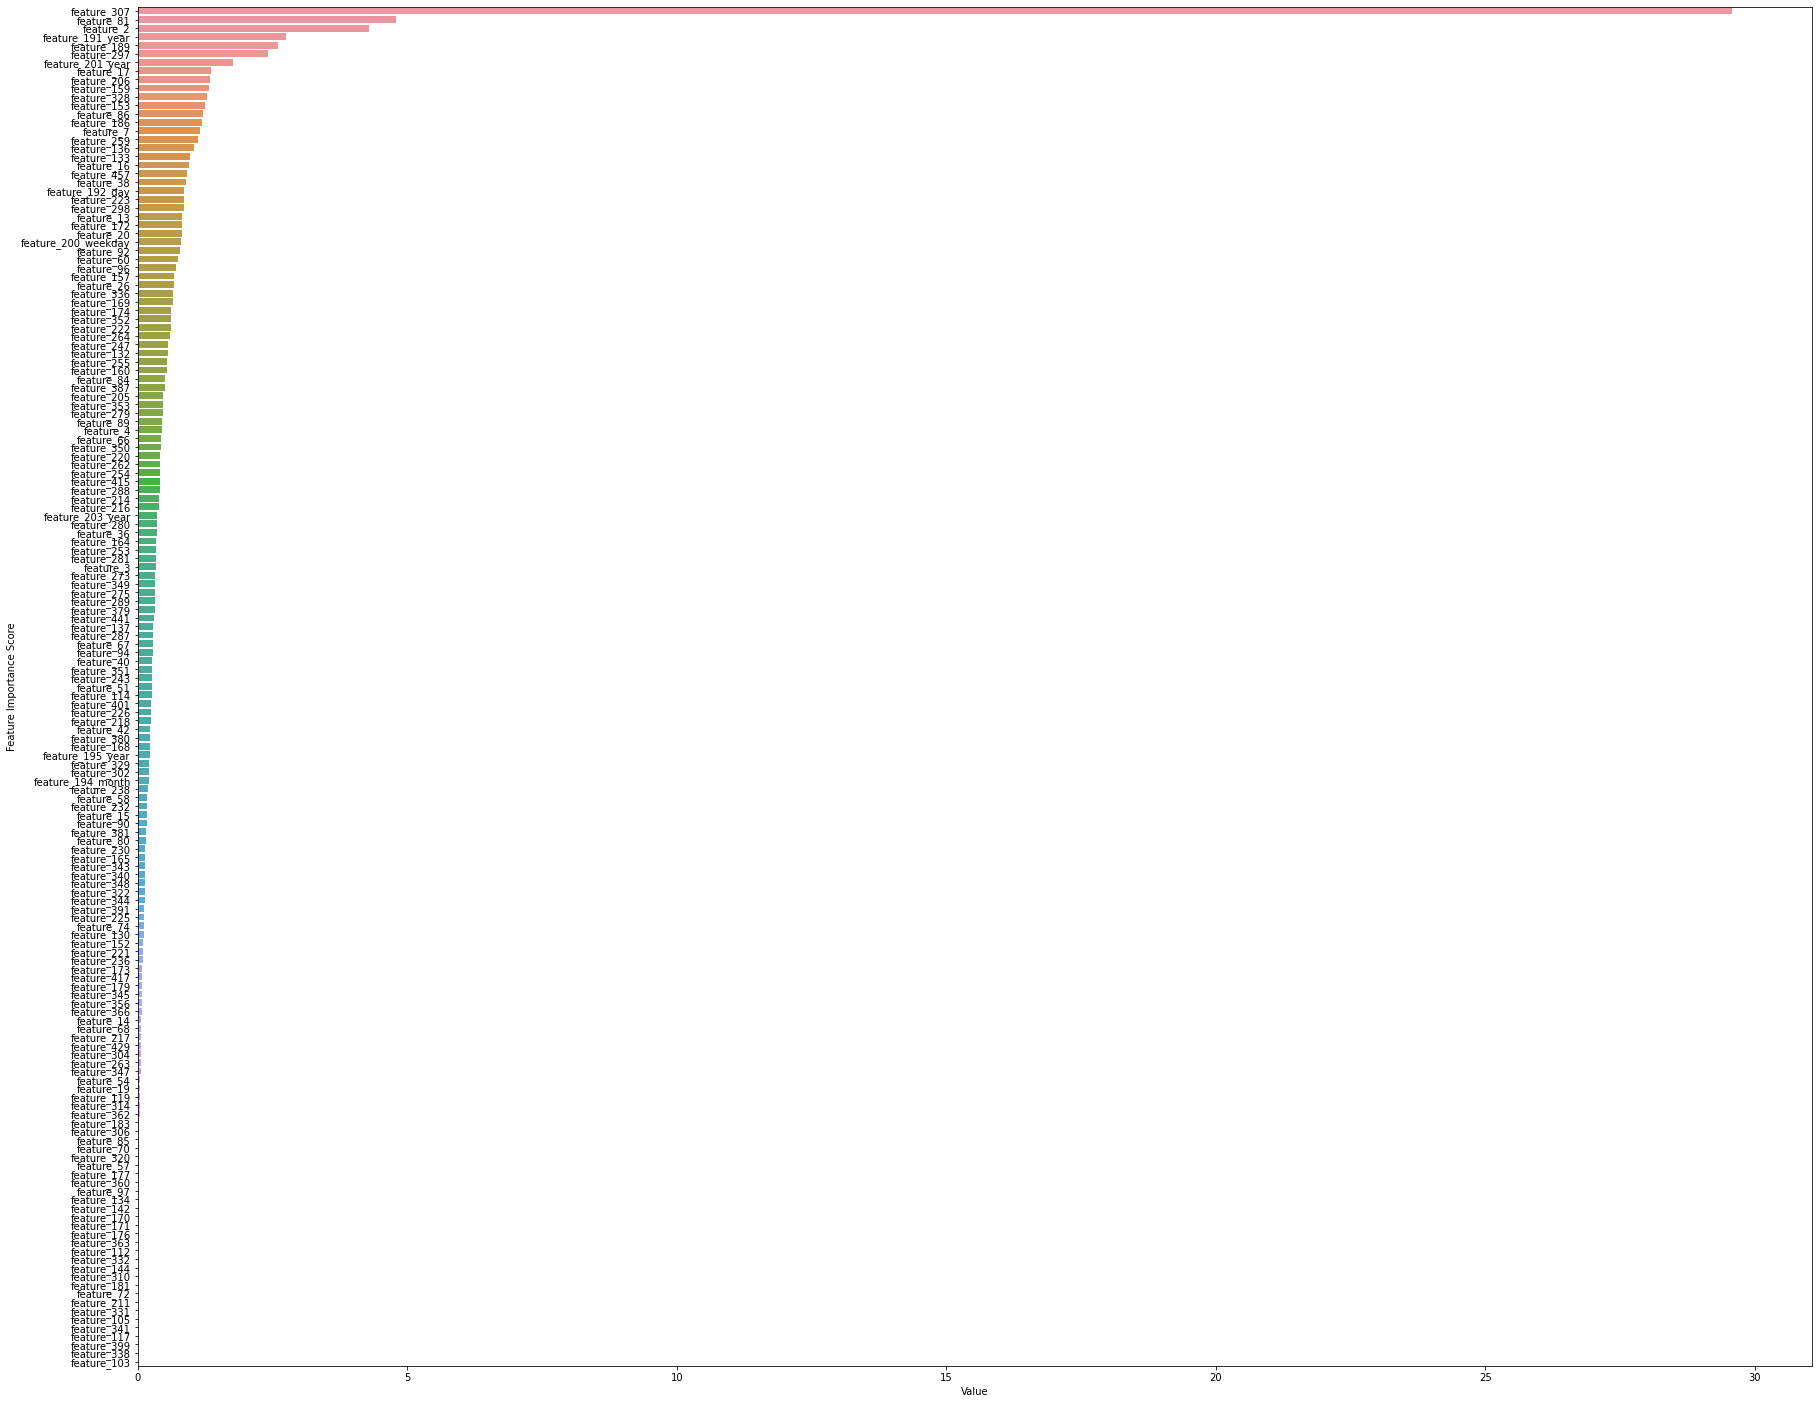

0.7862284113311659 0.8231229792561233 0.006420355636366859


In [9]:
catboost = cat(n_estimators=10000, max_depth=6, eval_metric='AUC', reg_lambda = 370)

func_= func(train, target, test, catboost, 'catboost', 16)
val_p1, test_p1, model1 = func_()

================================Fold1====================================
Learning rate set to 0.032385
0:	test: 0.7447453	best: 0.7447453 (0)	total: 51.8ms	remaining: 8m 38s
50:	test: 0.7651284	best: 0.7651284 (50)	total: 2.17s	remaining: 7m 3s
100:	test: 0.7733111	best: 0.7733133 (99)	total: 4.28s	remaining: 6m 59s
150:	test: 0.7765410	best: 0.7765410 (150)	total: 6.35s	remaining: 6m 54s
200:	test: 0.7777053	best: 0.7777053 (200)	total: 8.36s	remaining: 6m 47s
250:	test: 0.7784861	best: 0.7784861 (250)	total: 10.4s	remaining: 6m 45s
300:	test: 0.7789256	best: 0.7789256 (300)	total: 12.4s	remaining: 6m 40s
350:	test: 0.7794146	best: 0.7794780 (344)	total: 14.4s	remaining: 6m 36s
400:	test: 0.7798816	best: 0.7798912 (397)	total: 16.5s	remaining: 6m 34s
450:	test: 0.7800529	best: 0.7800529 (450)	total: 18.6s	remaining: 6m 34s
500:	test: 0.7802321	best: 0.7802321 (500)	total: 20.7s	remaining: 6m 32s
550:	test: 0.7802021	best: 0.7804151 (525)	total: 22.7s	remaining: 6m 29s
600:	test: 0.78

1500:	test: 0.7772453	best: 0.7775375 (1393)	total: 1m 1s	remaining: 5m 50s
1550:	test: 0.7773344	best: 0.7775375 (1393)	total: 1m 3s	remaining: 5m 47s
1600:	test: 0.7776376	best: 0.7776541 (1593)	total: 1m 5s	remaining: 5m 45s
1650:	test: 0.7776371	best: 0.7776756 (1606)	total: 1m 7s	remaining: 5m 42s
1700:	test: 0.7777684	best: 0.7778897 (1685)	total: 1m 9s	remaining: 5m 40s
1750:	test: 0.7775359	best: 0.7778897 (1685)	total: 1m 11s	remaining: 5m 38s
1800:	test: 0.7777347	best: 0.7778897 (1685)	total: 1m 13s	remaining: 5m 35s
1850:	test: 0.7779950	best: 0.7780299 (1839)	total: 1m 15s	remaining: 5m 33s
1900:	test: 0.7779753	best: 0.7780560 (1874)	total: 1m 17s	remaining: 5m 31s
1950:	test: 0.7780370	best: 0.7780708 (1937)	total: 1m 19s	remaining: 5m 29s
2000:	test: 0.7781030	best: 0.7781446 (1988)	total: 1m 21s	remaining: 5m 26s
2050:	test: 0.7782001	best: 0.7782795 (2039)	total: 1m 23s	remaining: 5m 24s
2100:	test: 0.7783840	best: 0.7783850 (2099)	total: 1m 25s	remaining: 5m 22s
2150

300:	test: 0.7759016	best: 0.7759016 (300)	total: 12.6s	remaining: 6m 44s
350:	test: 0.7766040	best: 0.7766040 (350)	total: 14.6s	remaining: 6m 41s
400:	test: 0.7773666	best: 0.7773666 (400)	total: 16.7s	remaining: 6m 38s
450:	test: 0.7779484	best: 0.7779665 (449)	total: 18.7s	remaining: 6m 35s
500:	test: 0.7781733	best: 0.7781850 (499)	total: 20.7s	remaining: 6m 31s
550:	test: 0.7783156	best: 0.7783156 (550)	total: 22.7s	remaining: 6m 29s
600:	test: 0.7786806	best: 0.7786806 (600)	total: 24.7s	remaining: 6m 26s
650:	test: 0.7788803	best: 0.7788849 (649)	total: 26.8s	remaining: 6m 24s
700:	test: 0.7789029	best: 0.7790582 (684)	total: 28.8s	remaining: 6m 21s
750:	test: 0.7791099	best: 0.7791331 (746)	total: 30.8s	remaining: 6m 19s
800:	test: 0.7792033	best: 0.7792045 (798)	total: 32.8s	remaining: 6m 16s
850:	test: 0.7794252	best: 0.7794253 (849)	total: 34.9s	remaining: 6m 14s
900:	test: 0.7796077	best: 0.7796294 (898)	total: 36.9s	remaining: 6m 12s
950:	test: 0.7794334	best: 0.7796838 (

500:	test: 0.7843153	best: 0.7843153 (500)	total: 20.6s	remaining: 6m 30s
550:	test: 0.7845642	best: 0.7845642 (550)	total: 22.6s	remaining: 6m 27s
600:	test: 0.7848492	best: 0.7848577 (575)	total: 24.6s	remaining: 6m 24s
650:	test: 0.7851051	best: 0.7851488 (629)	total: 26.6s	remaining: 6m 21s
700:	test: 0.7851582	best: 0.7852649 (693)	total: 28.6s	remaining: 6m 18s
750:	test: 0.7854011	best: 0.7854411 (747)	total: 30.7s	remaining: 6m 18s
800:	test: 0.7855601	best: 0.7856183 (796)	total: 32.8s	remaining: 6m 16s
850:	test: 0.7856814	best: 0.7857093 (832)	total: 34.8s	remaining: 6m 13s
900:	test: 0.7856756	best: 0.7857498 (868)	total: 36.7s	remaining: 6m 11s
950:	test: 0.7859214	best: 0.7859340 (942)	total: 38.8s	remaining: 6m 9s
1000:	test: 0.7859740	best: 0.7860699 (992)	total: 40.8s	remaining: 6m 6s
1050:	test: 0.7860383	best: 0.7861289 (1020)	total: 42.8s	remaining: 6m 4s
1100:	test: 0.7863356	best: 0.7863456 (1098)	total: 44.8s	remaining: 6m 2s
1150:	test: 0.7862248	best: 0.7863456

2250:	test: 0.8001309	best: 0.8002798 (1760)	total: 1m 33s	remaining: 5m 23s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8002797512
bestIteration = 1760

Shrink model to first 1761 iterations.

Validation scores 0.8002797512074583 0.48333326779319863
Training scores 0.8539210046632842 0.43202985829188156


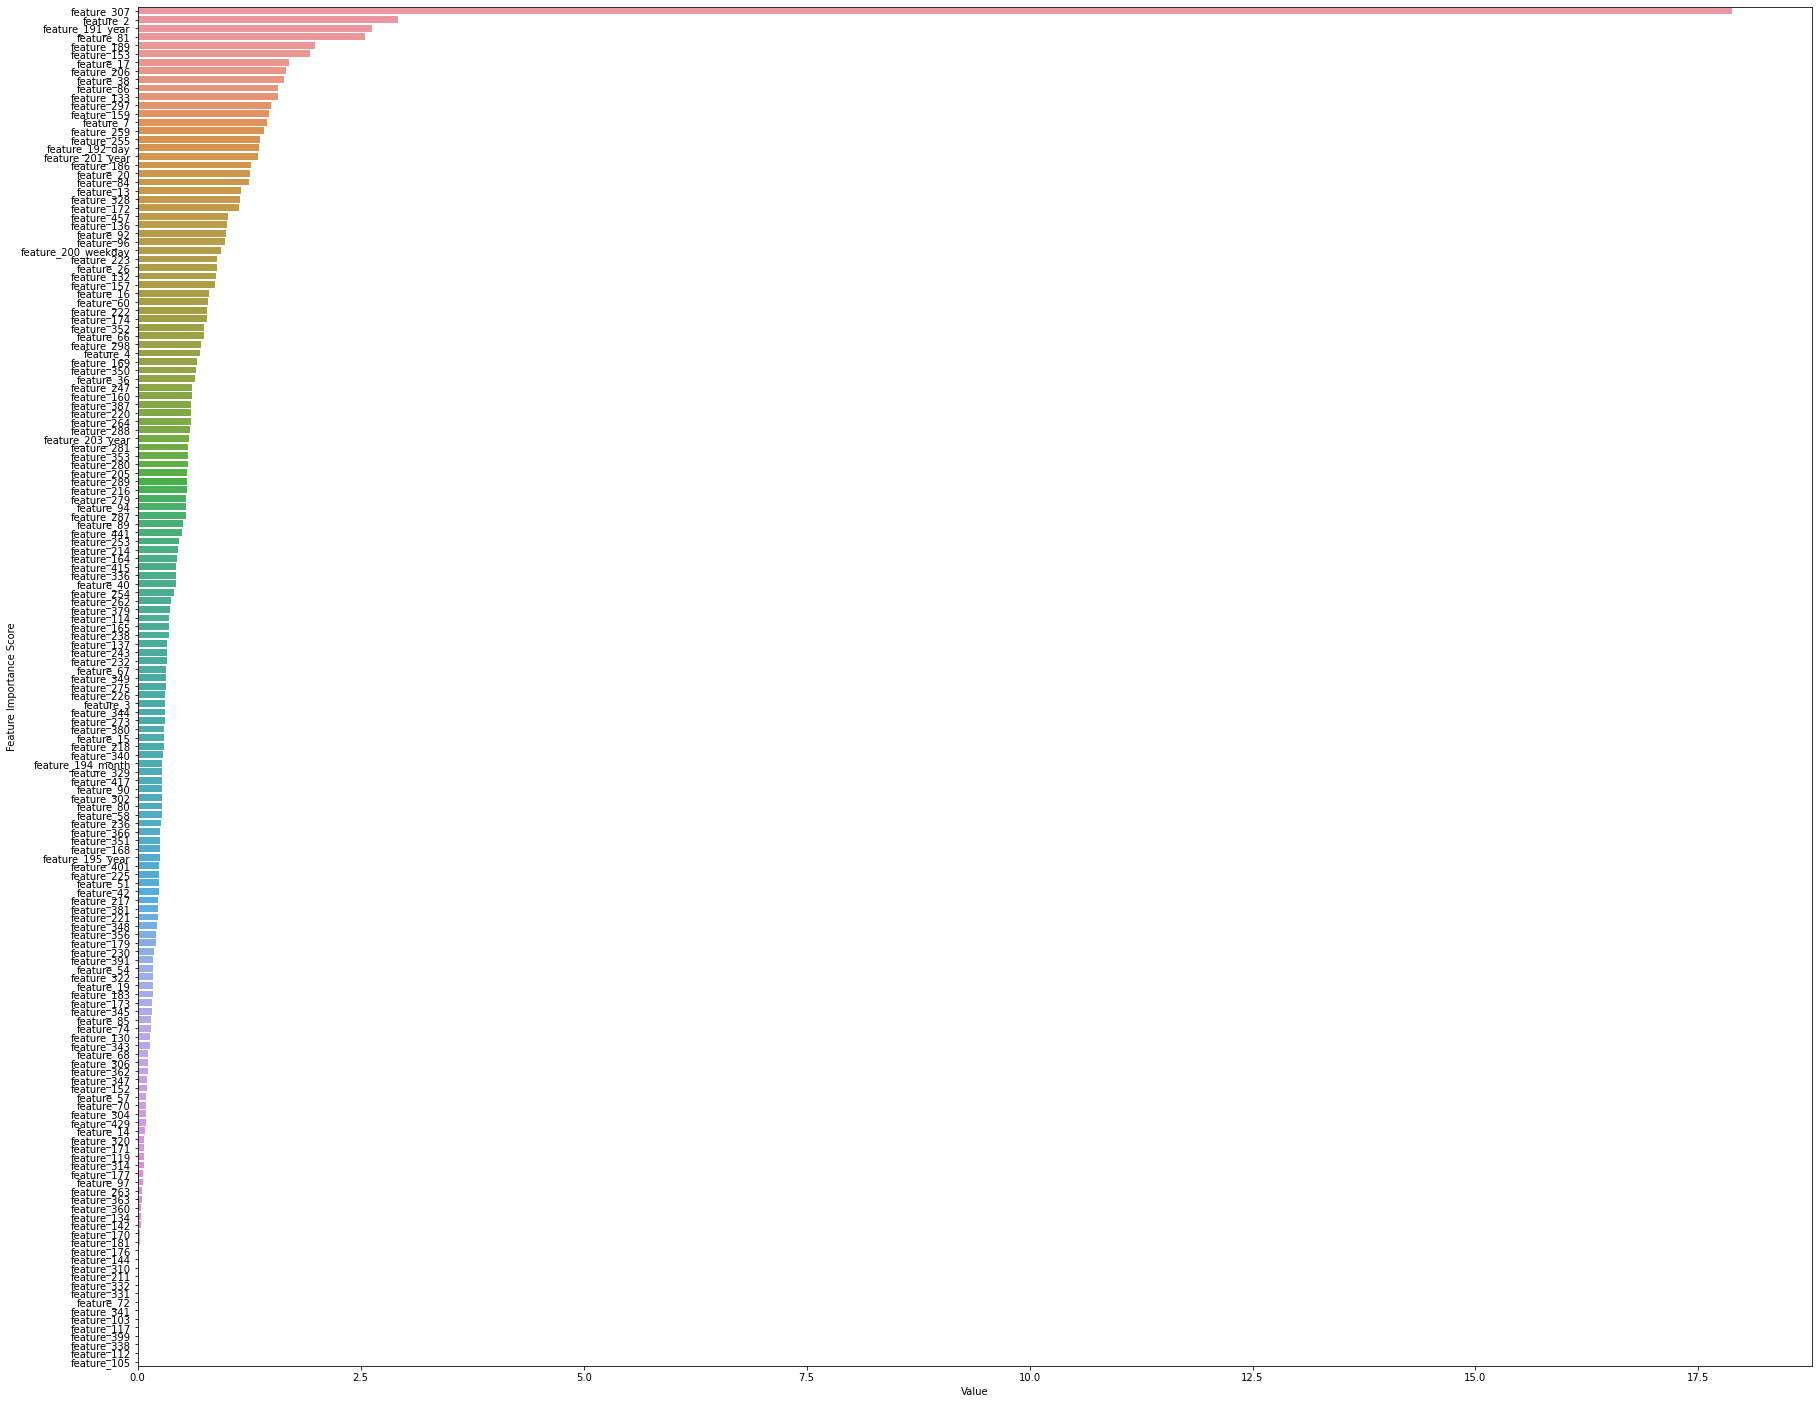

0.7861917001017007 0.8435550361430199 0.006541555354154334


In [10]:
#catboost = cat(n_estimators=10000, max_depth=6, eval_metric='AUC', reg_lambda = 370, task_type="GPU", devices='0:1',random_state=21)
catboost= cat(bootstrap_type='Bernoulli', 
                              iterations=10000, silent=True, eval_metric='AUC')
func_= func(train, target, test, catboost, 'catboost', 32)
val_p5, test_p5, model5 = func_()

In [11]:
from sklearn.linear_model import  LinearRegression, Ridge, Lasso
stack = np.column_stack((val_p1,val_p5))

stack_p = np.column_stack((test_p1,test_p5))

predict = LinearRegression().fit(stack, target).predict(stack_p)

In [12]:
submission['target'] = predict
submission.to_csv('latesubmissioncatboost.csv',index=False)

================================Fold1====================================
[1]	valid_0's auc: 0.750666
[2]	valid_0's auc: 0.759906
[3]	valid_0's auc: 0.765534
[4]	valid_0's auc: 0.76639
[5]	valid_0's auc: 0.766364
[6]	valid_0's auc: 0.768049
[7]	valid_0's auc: 0.769752
[8]	valid_0's auc: 0.770117
[9]	valid_0's auc: 0.770304
[10]	valid_0's auc: 0.770659
[11]	valid_0's auc: 0.771175
[12]	valid_0's auc: 0.771135
[13]	valid_0's auc: 0.771269
[14]	valid_0's auc: 0.771389
[15]	valid_0's auc: 0.771406
[16]	valid_0's auc: 0.771516
[17]	valid_0's auc: 0.77236
[18]	valid_0's auc: 0.772202
[19]	valid_0's auc: 0.772978
[20]	valid_0's auc: 0.773229
[21]	valid_0's auc: 0.773602
[22]	valid_0's auc: 0.773574
[23]	valid_0's auc: 0.773589
[24]	valid_0's auc: 0.773797
[25]	valid_0's auc: 0.77383
[26]	valid_0's auc: 0.773756
[27]	valid_0's auc: 0.773714
[28]	valid_0's auc: 0.773562
[29]	valid_0's auc: 0.773487
[30]	valid_0's auc: 0.773747
[31]	valid_0's auc: 0.77396
[32]	valid_0's auc: 0.774057
[33]	valid_

[278]	valid_0's auc: 0.779608
[279]	valid_0's auc: 0.779585
[280]	valid_0's auc: 0.779609
[281]	valid_0's auc: 0.779649
[282]	valid_0's auc: 0.779699
[283]	valid_0's auc: 0.77971
[284]	valid_0's auc: 0.779648
[285]	valid_0's auc: 0.779613
[286]	valid_0's auc: 0.779635
[287]	valid_0's auc: 0.779591
[288]	valid_0's auc: 0.779677
[289]	valid_0's auc: 0.779712
[290]	valid_0's auc: 0.779708
[291]	valid_0's auc: 0.779687
[292]	valid_0's auc: 0.779732
[293]	valid_0's auc: 0.779745
[294]	valid_0's auc: 0.779746
[295]	valid_0's auc: 0.779709
[296]	valid_0's auc: 0.779712
[297]	valid_0's auc: 0.779726
[298]	valid_0's auc: 0.779764
[299]	valid_0's auc: 0.779801
[300]	valid_0's auc: 0.779841
[301]	valid_0's auc: 0.779887
[302]	valid_0's auc: 0.779903
[303]	valid_0's auc: 0.779936
[304]	valid_0's auc: 0.779935
[305]	valid_0's auc: 0.779805
[306]	valid_0's auc: 0.779724
[307]	valid_0's auc: 0.779707
[308]	valid_0's auc: 0.779756
[309]	valid_0's auc: 0.779791
[310]	valid_0's auc: 0.779797
[311]	valid

[187]	valid_0's auc: 0.778873
[188]	valid_0's auc: 0.778893
[189]	valid_0's auc: 0.778901
[190]	valid_0's auc: 0.779055
[191]	valid_0's auc: 0.77909
[192]	valid_0's auc: 0.779098
[193]	valid_0's auc: 0.779177
[194]	valid_0's auc: 0.77916
[195]	valid_0's auc: 0.779206
[196]	valid_0's auc: 0.77925
[197]	valid_0's auc: 0.779129
[198]	valid_0's auc: 0.779246
[199]	valid_0's auc: 0.779292
[200]	valid_0's auc: 0.779325
[201]	valid_0's auc: 0.779316
[202]	valid_0's auc: 0.779362
[203]	valid_0's auc: 0.779328
[204]	valid_0's auc: 0.7793
[205]	valid_0's auc: 0.779321
[206]	valid_0's auc: 0.779387
[207]	valid_0's auc: 0.779311
[208]	valid_0's auc: 0.779318
[209]	valid_0's auc: 0.779331
[210]	valid_0's auc: 0.779324
[211]	valid_0's auc: 0.779335
[212]	valid_0's auc: 0.779309
[213]	valid_0's auc: 0.779294
[214]	valid_0's auc: 0.779266
[215]	valid_0's auc: 0.779267
[216]	valid_0's auc: 0.779245
[217]	valid_0's auc: 0.779264
[218]	valid_0's auc: 0.779282
[219]	valid_0's auc: 0.779254
[220]	valid_0's

[464]	valid_0's auc: 0.779617
[465]	valid_0's auc: 0.779595
[466]	valid_0's auc: 0.779562
[467]	valid_0's auc: 0.779524
[468]	valid_0's auc: 0.779518
[469]	valid_0's auc: 0.779475
[470]	valid_0's auc: 0.779551
[471]	valid_0's auc: 0.779643
[472]	valid_0's auc: 0.779722
[473]	valid_0's auc: 0.779694
[474]	valid_0's auc: 0.779713
[475]	valid_0's auc: 0.77972
[476]	valid_0's auc: 0.779715
[477]	valid_0's auc: 0.779662
[478]	valid_0's auc: 0.77962
[479]	valid_0's auc: 0.779481
[480]	valid_0's auc: 0.779485
[481]	valid_0's auc: 0.779463
[482]	valid_0's auc: 0.779458
[483]	valid_0's auc: 0.779372
[484]	valid_0's auc: 0.77935
[485]	valid_0's auc: 0.779358
[486]	valid_0's auc: 0.779265
[487]	valid_0's auc: 0.779267
[488]	valid_0's auc: 0.779267
[489]	valid_0's auc: 0.779279
[490]	valid_0's auc: 0.779278
[491]	valid_0's auc: 0.77926
[492]	valid_0's auc: 0.779249
[493]	valid_0's auc: 0.779232
[494]	valid_0's auc: 0.779225
[495]	valid_0's auc: 0.779145
[496]	valid_0's auc: 0.779175
[497]	valid_0'

[144]	valid_0's auc: 0.77647
[145]	valid_0's auc: 0.776441
[146]	valid_0's auc: 0.776434
[147]	valid_0's auc: 0.776479
[148]	valid_0's auc: 0.776504
[149]	valid_0's auc: 0.776445
[150]	valid_0's auc: 0.776464
[151]	valid_0's auc: 0.776528
[152]	valid_0's auc: 0.776685
[153]	valid_0's auc: 0.776772
[154]	valid_0's auc: 0.77688
[155]	valid_0's auc: 0.776881
[156]	valid_0's auc: 0.776951
[157]	valid_0's auc: 0.776868
[158]	valid_0's auc: 0.77695
[159]	valid_0's auc: 0.777017
[160]	valid_0's auc: 0.777166
[161]	valid_0's auc: 0.777138
[162]	valid_0's auc: 0.777171
[163]	valid_0's auc: 0.777132
[164]	valid_0's auc: 0.777135
[165]	valid_0's auc: 0.777163
[166]	valid_0's auc: 0.777287
[167]	valid_0's auc: 0.777361
[168]	valid_0's auc: 0.777439
[169]	valid_0's auc: 0.777513
[170]	valid_0's auc: 0.777509
[171]	valid_0's auc: 0.777479
[172]	valid_0's auc: 0.777445
[173]	valid_0's auc: 0.777391
[174]	valid_0's auc: 0.777366
[175]	valid_0's auc: 0.777424
[176]	valid_0's auc: 0.777463
[177]	valid_0

[25]	valid_0's auc: 0.780266
[26]	valid_0's auc: 0.780118
[27]	valid_0's auc: 0.780238
[28]	valid_0's auc: 0.78063
[29]	valid_0's auc: 0.780659
[30]	valid_0's auc: 0.780839
[31]	valid_0's auc: 0.780976
[32]	valid_0's auc: 0.780943
[33]	valid_0's auc: 0.781016
[34]	valid_0's auc: 0.781103
[35]	valid_0's auc: 0.781268
[36]	valid_0's auc: 0.781382
[37]	valid_0's auc: 0.781462
[38]	valid_0's auc: 0.781618
[39]	valid_0's auc: 0.781698
[40]	valid_0's auc: 0.781725
[41]	valid_0's auc: 0.781747
[42]	valid_0's auc: 0.782064
[43]	valid_0's auc: 0.782027
[44]	valid_0's auc: 0.782102
[45]	valid_0's auc: 0.782274
[46]	valid_0's auc: 0.782403
[47]	valid_0's auc: 0.782528
[48]	valid_0's auc: 0.782794
[49]	valid_0's auc: 0.782965
[50]	valid_0's auc: 0.782931
[51]	valid_0's auc: 0.782991
[52]	valid_0's auc: 0.78303
[53]	valid_0's auc: 0.783208
[54]	valid_0's auc: 0.783466
[55]	valid_0's auc: 0.783559
[56]	valid_0's auc: 0.783661
[57]	valid_0's auc: 0.783824
[58]	valid_0's auc: 0.783946
[59]	valid_0's a

[306]	valid_0's auc: 0.788426
[307]	valid_0's auc: 0.788372
[308]	valid_0's auc: 0.788356
[309]	valid_0's auc: 0.788354
[310]	valid_0's auc: 0.78829
[311]	valid_0's auc: 0.788312
[312]	valid_0's auc: 0.788262
[313]	valid_0's auc: 0.78831
[314]	valid_0's auc: 0.78826
[315]	valid_0's auc: 0.78818
[316]	valid_0's auc: 0.788013
[317]	valid_0's auc: 0.788036
[318]	valid_0's auc: 0.78813
[319]	valid_0's auc: 0.788202
[320]	valid_0's auc: 0.788201
[321]	valid_0's auc: 0.788189
[322]	valid_0's auc: 0.788164
[323]	valid_0's auc: 0.788109
[324]	valid_0's auc: 0.788042
[325]	valid_0's auc: 0.787994
[326]	valid_0's auc: 0.788012
[327]	valid_0's auc: 0.78801
[328]	valid_0's auc: 0.788066
[329]	valid_0's auc: 0.787994
[330]	valid_0's auc: 0.787943
[331]	valid_0's auc: 0.787986
[332]	valid_0's auc: 0.78799
[333]	valid_0's auc: 0.788014
[334]	valid_0's auc: 0.78799
[335]	valid_0's auc: 0.787915
[336]	valid_0's auc: 0.788009
[337]	valid_0's auc: 0.787957
[338]	valid_0's auc: 0.787884
[339]	valid_0's au

[177]	valid_0's auc: 0.792827
[178]	valid_0's auc: 0.792886
[179]	valid_0's auc: 0.792893
[180]	valid_0's auc: 0.792942
[181]	valid_0's auc: 0.792976
[182]	valid_0's auc: 0.792945
[183]	valid_0's auc: 0.793021
[184]	valid_0's auc: 0.79298
[185]	valid_0's auc: 0.792911
[186]	valid_0's auc: 0.792829
[187]	valid_0's auc: 0.792894
[188]	valid_0's auc: 0.792865
[189]	valid_0's auc: 0.792864
[190]	valid_0's auc: 0.79292
[191]	valid_0's auc: 0.79278
[192]	valid_0's auc: 0.792863
[193]	valid_0's auc: 0.792888
[194]	valid_0's auc: 0.79291
[195]	valid_0's auc: 0.792896
[196]	valid_0's auc: 0.792851
[197]	valid_0's auc: 0.792892
[198]	valid_0's auc: 0.792849
[199]	valid_0's auc: 0.792879
[200]	valid_0's auc: 0.792915
[201]	valid_0's auc: 0.792988
[202]	valid_0's auc: 0.792923
[203]	valid_0's auc: 0.793011
[204]	valid_0's auc: 0.792996
[205]	valid_0's auc: 0.793014
[206]	valid_0's auc: 0.792921
[207]	valid_0's auc: 0.792924
[208]	valid_0's auc: 0.792902
[209]	valid_0's auc: 0.792847
[210]	valid_0'

[67]	valid_0's auc: 0.774732
[68]	valid_0's auc: 0.774904
[69]	valid_0's auc: 0.775151
[70]	valid_0's auc: 0.775166
[71]	valid_0's auc: 0.775283
[72]	valid_0's auc: 0.775166
[73]	valid_0's auc: 0.775219
[74]	valid_0's auc: 0.77526
[75]	valid_0's auc: 0.775324
[76]	valid_0's auc: 0.775238
[77]	valid_0's auc: 0.775375
[78]	valid_0's auc: 0.775516
[79]	valid_0's auc: 0.775399
[80]	valid_0's auc: 0.775565
[81]	valid_0's auc: 0.775749
[82]	valid_0's auc: 0.77588
[83]	valid_0's auc: 0.77585
[84]	valid_0's auc: 0.77605
[85]	valid_0's auc: 0.776239
[86]	valid_0's auc: 0.776372
[87]	valid_0's auc: 0.776396
[88]	valid_0's auc: 0.776388
[89]	valid_0's auc: 0.776401
[90]	valid_0's auc: 0.776404
[91]	valid_0's auc: 0.776425
[92]	valid_0's auc: 0.7765
[93]	valid_0's auc: 0.776384
[94]	valid_0's auc: 0.77634
[95]	valid_0's auc: 0.776407
[96]	valid_0's auc: 0.776534
[97]	valid_0's auc: 0.7767
[98]	valid_0's auc: 0.776788
[99]	valid_0's auc: 0.77688
[100]	valid_0's auc: 0.776829
[101]	valid_0's auc: 0.

[348]	valid_0's auc: 0.779753
[349]	valid_0's auc: 0.779772
[350]	valid_0's auc: 0.779845
[351]	valid_0's auc: 0.77988
[352]	valid_0's auc: 0.779923
[353]	valid_0's auc: 0.779885
[354]	valid_0's auc: 0.779955
[355]	valid_0's auc: 0.779984
[356]	valid_0's auc: 0.779967
[357]	valid_0's auc: 0.779966
[358]	valid_0's auc: 0.779989
[359]	valid_0's auc: 0.780047
[360]	valid_0's auc: 0.779984
[361]	valid_0's auc: 0.779962
[362]	valid_0's auc: 0.77997
[363]	valid_0's auc: 0.779997
[364]	valid_0's auc: 0.780078
[365]	valid_0's auc: 0.780027
[366]	valid_0's auc: 0.780027
[367]	valid_0's auc: 0.780039
[368]	valid_0's auc: 0.779925
[369]	valid_0's auc: 0.779951
[370]	valid_0's auc: 0.779936
[371]	valid_0's auc: 0.779956
[372]	valid_0's auc: 0.779974
[373]	valid_0's auc: 0.779994
[374]	valid_0's auc: 0.78001
[375]	valid_0's auc: 0.779972
[376]	valid_0's auc: 0.779957
[377]	valid_0's auc: 0.779976
[378]	valid_0's auc: 0.780024
[379]	valid_0's auc: 0.780065
[380]	valid_0's auc: 0.780091
[381]	valid_0

[626]	valid_0's auc: 0.779898
[627]	valid_0's auc: 0.7799
[628]	valid_0's auc: 0.77988
[629]	valid_0's auc: 0.779851
[630]	valid_0's auc: 0.779903
[631]	valid_0's auc: 0.779874
[632]	valid_0's auc: 0.779902
[633]	valid_0's auc: 0.779842
[634]	valid_0's auc: 0.779861
[635]	valid_0's auc: 0.779774
[636]	valid_0's auc: 0.779806
[637]	valid_0's auc: 0.779857
[638]	valid_0's auc: 0.779823
[639]	valid_0's auc: 0.779814
[640]	valid_0's auc: 0.779763
[641]	valid_0's auc: 0.779702
[642]	valid_0's auc: 0.779638
[643]	valid_0's auc: 0.779639
[644]	valid_0's auc: 0.77963
[645]	valid_0's auc: 0.779584
[646]	valid_0's auc: 0.779591
[647]	valid_0's auc: 0.779521
[648]	valid_0's auc: 0.779556
[649]	valid_0's auc: 0.779506
[650]	valid_0's auc: 0.779468
[651]	valid_0's auc: 0.779475
[652]	valid_0's auc: 0.779458
[653]	valid_0's auc: 0.779478
[654]	valid_0's auc: 0.779533
[655]	valid_0's auc: 0.779534
[656]	valid_0's auc: 0.779528
[657]	valid_0's auc: 0.779458
[658]	valid_0's auc: 0.779462
[659]	valid_0'

[79]	valid_0's auc: 0.780714
[80]	valid_0's auc: 0.780861
[81]	valid_0's auc: 0.780853
[82]	valid_0's auc: 0.780952
[83]	valid_0's auc: 0.780898
[84]	valid_0's auc: 0.781073
[85]	valid_0's auc: 0.781319
[86]	valid_0's auc: 0.781282
[87]	valid_0's auc: 0.781262
[88]	valid_0's auc: 0.781343
[89]	valid_0's auc: 0.781512
[90]	valid_0's auc: 0.781668
[91]	valid_0's auc: 0.78173
[92]	valid_0's auc: 0.781653
[93]	valid_0's auc: 0.781765
[94]	valid_0's auc: 0.781738
[95]	valid_0's auc: 0.781895
[96]	valid_0's auc: 0.781904
[97]	valid_0's auc: 0.781963
[98]	valid_0's auc: 0.782074
[99]	valid_0's auc: 0.782127
[100]	valid_0's auc: 0.782114
[101]	valid_0's auc: 0.782322
[102]	valid_0's auc: 0.782334
[103]	valid_0's auc: 0.782373
[104]	valid_0's auc: 0.782319
[105]	valid_0's auc: 0.782317
[106]	valid_0's auc: 0.782566
[107]	valid_0's auc: 0.782613
[108]	valid_0's auc: 0.78267
[109]	valid_0's auc: 0.782725
[110]	valid_0's auc: 0.782764
[111]	valid_0's auc: 0.78296
[112]	valid_0's auc: 0.78302
[113]

[356]	valid_0's auc: 0.78653
[357]	valid_0's auc: 0.786543
[358]	valid_0's auc: 0.78651
[359]	valid_0's auc: 0.78641
[360]	valid_0's auc: 0.786444
[361]	valid_0's auc: 0.786381
[362]	valid_0's auc: 0.786369
[363]	valid_0's auc: 0.786383
[364]	valid_0's auc: 0.786372
[365]	valid_0's auc: 0.786394
[366]	valid_0's auc: 0.786381
[367]	valid_0's auc: 0.786375
[368]	valid_0's auc: 0.786275
[369]	valid_0's auc: 0.786309
[370]	valid_0's auc: 0.786347
[371]	valid_0's auc: 0.786377
[372]	valid_0's auc: 0.786442
[373]	valid_0's auc: 0.786524
[374]	valid_0's auc: 0.786453
[375]	valid_0's auc: 0.786415
[376]	valid_0's auc: 0.786399
[377]	valid_0's auc: 0.786478
[378]	valid_0's auc: 0.786514
[379]	valid_0's auc: 0.786551
[380]	valid_0's auc: 0.786592
[381]	valid_0's auc: 0.786564
[382]	valid_0's auc: 0.786541
[383]	valid_0's auc: 0.78661
[384]	valid_0's auc: 0.7866
[385]	valid_0's auc: 0.786637
[386]	valid_0's auc: 0.786736
[387]	valid_0's auc: 0.786764
[388]	valid_0's auc: 0.78669
[389]	valid_0's a

[31]	valid_0's auc: 0.774745
[32]	valid_0's auc: 0.774741
[33]	valid_0's auc: 0.774848
[34]	valid_0's auc: 0.774869
[35]	valid_0's auc: 0.775036
[36]	valid_0's auc: 0.775223
[37]	valid_0's auc: 0.775424
[38]	valid_0's auc: 0.775565
[39]	valid_0's auc: 0.775618
[40]	valid_0's auc: 0.775801
[41]	valid_0's auc: 0.775949
[42]	valid_0's auc: 0.775986
[43]	valid_0's auc: 0.775923
[44]	valid_0's auc: 0.776093
[45]	valid_0's auc: 0.776509
[46]	valid_0's auc: 0.776867
[47]	valid_0's auc: 0.776931
[48]	valid_0's auc: 0.777007
[49]	valid_0's auc: 0.776996
[50]	valid_0's auc: 0.777002
[51]	valid_0's auc: 0.777228
[52]	valid_0's auc: 0.777308
[53]	valid_0's auc: 0.777574
[54]	valid_0's auc: 0.777651
[55]	valid_0's auc: 0.777941
[56]	valid_0's auc: 0.778172
[57]	valid_0's auc: 0.77843
[58]	valid_0's auc: 0.778537
[59]	valid_0's auc: 0.778771
[60]	valid_0's auc: 0.778902
[61]	valid_0's auc: 0.778947
[62]	valid_0's auc: 0.77913
[63]	valid_0's auc: 0.779217
[64]	valid_0's auc: 0.779348
[65]	valid_0's a

[308]	valid_0's auc: 0.785826
[309]	valid_0's auc: 0.785862
[310]	valid_0's auc: 0.785806
[311]	valid_0's auc: 0.785779
[312]	valid_0's auc: 0.785798
[313]	valid_0's auc: 0.78583
[314]	valid_0's auc: 0.785842
[315]	valid_0's auc: 0.785776
[316]	valid_0's auc: 0.785708
[317]	valid_0's auc: 0.785648
[318]	valid_0's auc: 0.785686
[319]	valid_0's auc: 0.785729
[320]	valid_0's auc: 0.785731
[321]	valid_0's auc: 0.785758
[322]	valid_0's auc: 0.785774
[323]	valid_0's auc: 0.785793
[324]	valid_0's auc: 0.785825
[325]	valid_0's auc: 0.78592
[326]	valid_0's auc: 0.78591
[327]	valid_0's auc: 0.785891
[328]	valid_0's auc: 0.785966
[329]	valid_0's auc: 0.785961
[330]	valid_0's auc: 0.785956
[331]	valid_0's auc: 0.785865
[332]	valid_0's auc: 0.785926
[333]	valid_0's auc: 0.785833
[334]	valid_0's auc: 0.785824
[335]	valid_0's auc: 0.785823
[336]	valid_0's auc: 0.785805
[337]	valid_0's auc: 0.785785
[338]	valid_0's auc: 0.785867
[339]	valid_0's auc: 0.786006
[340]	valid_0's auc: 0.786156
[341]	valid_0

[43]	valid_0's auc: 0.778874
[44]	valid_0's auc: 0.778873
[45]	valid_0's auc: 0.778919
[46]	valid_0's auc: 0.779203
[47]	valid_0's auc: 0.779336
[48]	valid_0's auc: 0.779391
[49]	valid_0's auc: 0.779479
[50]	valid_0's auc: 0.779652
[51]	valid_0's auc: 0.779738
[52]	valid_0's auc: 0.779765
[53]	valid_0's auc: 0.779829
[54]	valid_0's auc: 0.779933
[55]	valid_0's auc: 0.780046
[56]	valid_0's auc: 0.78007
[57]	valid_0's auc: 0.779971
[58]	valid_0's auc: 0.779989
[59]	valid_0's auc: 0.78012
[60]	valid_0's auc: 0.780253
[61]	valid_0's auc: 0.780204
[62]	valid_0's auc: 0.780396
[63]	valid_0's auc: 0.780474
[64]	valid_0's auc: 0.780559
[65]	valid_0's auc: 0.780507
[66]	valid_0's auc: 0.780439
[67]	valid_0's auc: 0.78047
[68]	valid_0's auc: 0.780619
[69]	valid_0's auc: 0.780672
[70]	valid_0's auc: 0.780751
[71]	valid_0's auc: 0.780811
[72]	valid_0's auc: 0.78091
[73]	valid_0's auc: 0.781102
[74]	valid_0's auc: 0.78138
[75]	valid_0's auc: 0.781578
[76]	valid_0's auc: 0.78185
[77]	valid_0's auc: 

[321]	valid_0's auc: 0.783955
[322]	valid_0's auc: 0.783939
[323]	valid_0's auc: 0.783951
[324]	valid_0's auc: 0.783993
[325]	valid_0's auc: 0.784067
[326]	valid_0's auc: 0.784163
[327]	valid_0's auc: 0.784143
[328]	valid_0's auc: 0.784068
[329]	valid_0's auc: 0.784074
[330]	valid_0's auc: 0.784042
[331]	valid_0's auc: 0.784103
[332]	valid_0's auc: 0.784061
[333]	valid_0's auc: 0.784042
[334]	valid_0's auc: 0.784094
[335]	valid_0's auc: 0.784093
[336]	valid_0's auc: 0.784065
[337]	valid_0's auc: 0.784083
[338]	valid_0's auc: 0.784062
[339]	valid_0's auc: 0.784086
[340]	valid_0's auc: 0.784093
[341]	valid_0's auc: 0.784111
[342]	valid_0's auc: 0.78406
[343]	valid_0's auc: 0.783979
[344]	valid_0's auc: 0.7839
[345]	valid_0's auc: 0.783929
[346]	valid_0's auc: 0.783954
[347]	valid_0's auc: 0.784006
[348]	valid_0's auc: 0.784025
[349]	valid_0's auc: 0.78405
[350]	valid_0's auc: 0.784001
[351]	valid_0's auc: 0.784065
[352]	valid_0's auc: 0.784105
[353]	valid_0's auc: 0.784146
[354]	valid_0'

[103]	valid_0's auc: 0.795136
[104]	valid_0's auc: 0.795083
[105]	valid_0's auc: 0.795238
[106]	valid_0's auc: 0.79537
[107]	valid_0's auc: 0.795428
[108]	valid_0's auc: 0.795581
[109]	valid_0's auc: 0.795553
[110]	valid_0's auc: 0.795642
[111]	valid_0's auc: 0.795645
[112]	valid_0's auc: 0.795711
[113]	valid_0's auc: 0.795801
[114]	valid_0's auc: 0.795728
[115]	valid_0's auc: 0.795803
[116]	valid_0's auc: 0.795879
[117]	valid_0's auc: 0.795791
[118]	valid_0's auc: 0.795817
[119]	valid_0's auc: 0.795766
[120]	valid_0's auc: 0.79582
[121]	valid_0's auc: 0.795809
[122]	valid_0's auc: 0.795855
[123]	valid_0's auc: 0.795961
[124]	valid_0's auc: 0.795895
[125]	valid_0's auc: 0.796135
[126]	valid_0's auc: 0.796109
[127]	valid_0's auc: 0.796162
[128]	valid_0's auc: 0.796226
[129]	valid_0's auc: 0.796216
[130]	valid_0's auc: 0.796156
[131]	valid_0's auc: 0.796119
[132]	valid_0's auc: 0.796145
[133]	valid_0's auc: 0.796206
[134]	valid_0's auc: 0.796243
[135]	valid_0's auc: 0.796216
[136]	valid_

[383]	valid_0's auc: 0.796463
[384]	valid_0's auc: 0.796438
[385]	valid_0's auc: 0.796409
[386]	valid_0's auc: 0.796375
[387]	valid_0's auc: 0.796384
[388]	valid_0's auc: 0.796346
[389]	valid_0's auc: 0.79635
[390]	valid_0's auc: 0.796366
[391]	valid_0's auc: 0.796425
[392]	valid_0's auc: 0.796404
[393]	valid_0's auc: 0.796399
[394]	valid_0's auc: 0.796375
[395]	valid_0's auc: 0.796361
[396]	valid_0's auc: 0.796321
[397]	valid_0's auc: 0.796275
[398]	valid_0's auc: 0.796258
[399]	valid_0's auc: 0.796322
[400]	valid_0's auc: 0.796264
[401]	valid_0's auc: 0.796284
[402]	valid_0's auc: 0.796189
[403]	valid_0's auc: 0.796158
[404]	valid_0's auc: 0.796185
[405]	valid_0's auc: 0.796189
[406]	valid_0's auc: 0.796189
[407]	valid_0's auc: 0.796168
[408]	valid_0's auc: 0.796165
[409]	valid_0's auc: 0.796164
[410]	valid_0's auc: 0.796044
[411]	valid_0's auc: 0.796033
[412]	valid_0's auc: 0.795973
[413]	valid_0's auc: 0.795879
[414]	valid_0's auc: 0.795938
[415]	valid_0's auc: 0.795882
[416]	valid

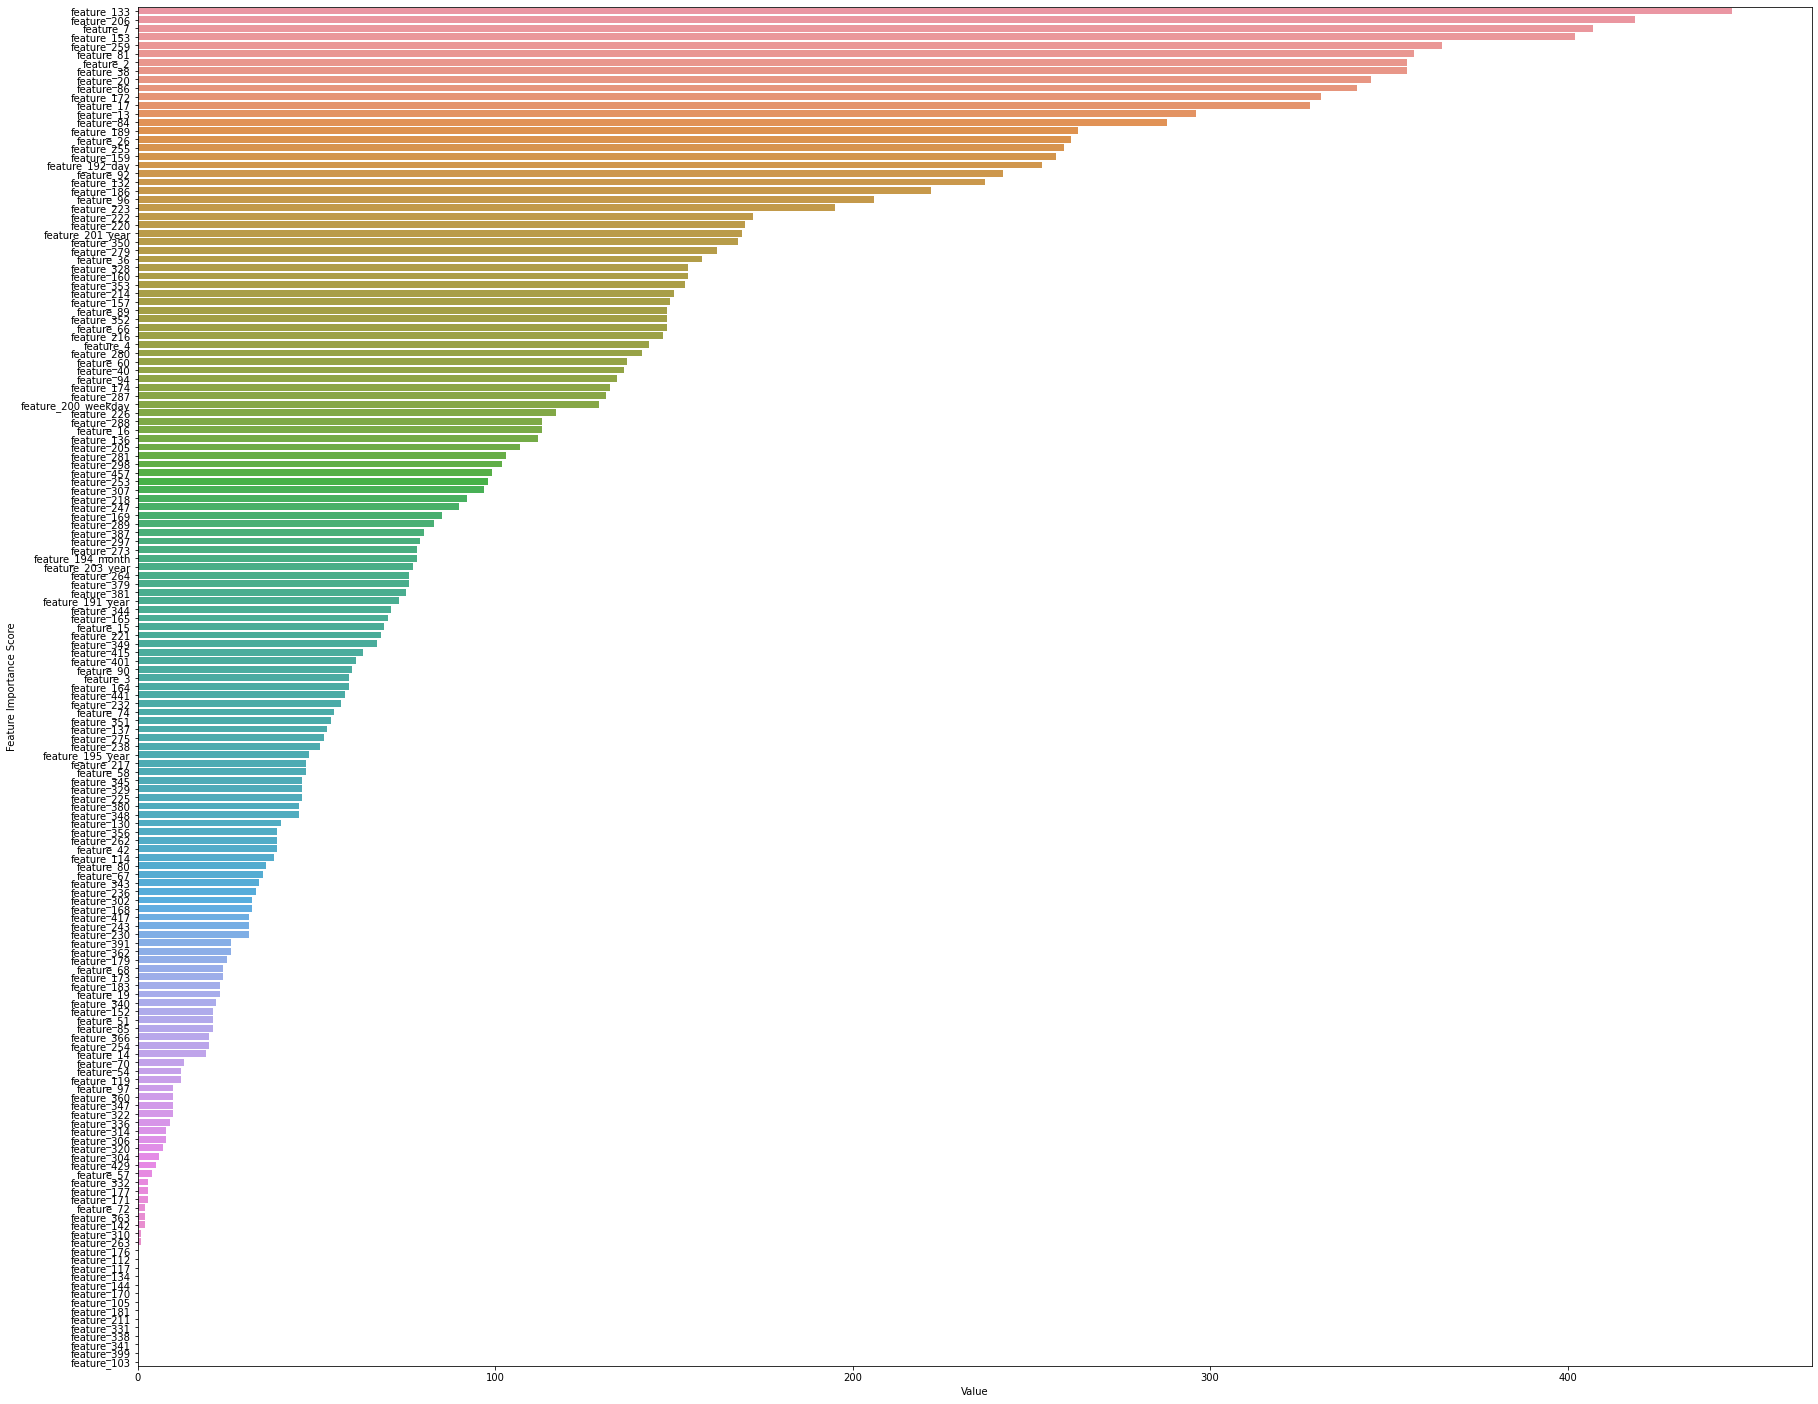

0.7856604583389846 0.8697325097845028 0.006023772493024742


In [13]:
lgb_model = lgb.LGBMClassifier( n_estimators=1000, metric='AUC', learning_rate=0.04, subsample=0.7,
                         colsample_bytree=0.8, num_leaves=64, reg_alpha=4, min_child_samples=5,subsample_freq=2)

func_= func(train, target, test, lgb_model, 'lgbm',777)
val_p4, test_p4, model4 = func_()


In [14]:
stack = np.column_stack((val_p1,val_p4,val_p5))
stack_p = np.column_stack((test_p1,test_p4,test_p5))
predict = LinearRegression().fit(stack, target).predict(stack_p)


In [15]:
submission['target'] = predict
submission.to_csv('latesubmissionmoremodels.csv',index=False)